# Group Ensemble

### Getting Data

In [0]:
#If the long url below doesn't work, run the shrorter URL to get the new URL
#!curl "https://drive.google.com/uc?export=download&id=1gYFou8KJGxL-4tG7Ut4ptVmfLjPXRLxw"
!curl "https://doc-04-00-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/edde69seqvu884lgpj6cdpi3c65vr3c0/1573315200000/12424731692871738664/*/1gYFou8KJGxL-4tG7Ut4ptVmfLjPXRLxw?e=download" > magic04.csv
!ls
!head magic04.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1442k  100 1442k    0     0   249k      0  0:00:05  0:00:05 --:--:--  337k
magic04.csv  sample_data
fLen0t1,fWidt1,fSize,fConc,fConc1,fAsym,fM3Lon0,fM3Trans,fAlp1a,fDist,class
28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.011,-8.2027,40.092,81.8828,0
31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.261,0
162.052,136.031,4.0612,0.0374,0.0187,116.741,-64.858,-45.216,76.96,256.788,0
23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.449,116.737,0
75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.648,356.462,0
51.624,21.1502,2.9085,0.242,0.134,50.8761,43.1887,9.8145,3.613,238.098,0
48.2468,17.3565,3.0332,0.2529,0.1515,8.573,38.0957,10.5868,4.792,219.087,0
26.7897,13.7595,2.5521,0.4236,0.2174,29.6339,20.456,-2.9292,0.812,237.134,0
96.2327,46.5165,4.154,0.0779,0.039,110.355,85.0486,4

###Creating Ensemble

####Imports, Prep Code

In [0]:
!pip install xgboost
import xgboost as xgb
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import pandas as pd
import numpy as np

data = pd.read_csv("magic04.csv")

X = data.iloc[:, :-1] 
Y = data['class']

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = 0, test_size = 0.3)
#X_train = X_train.to_numpy()

####Alex's Ensemble

In [0]:
bestForest = None
bestFalsePositiveRate = 1

for attempt in range(10):
    for forestSize in range(1, 50):
        ensemble = RandomForestClassifier(n_estimators = forestSize, n_jobs = -1).fit(X_train, y_train)
        testFalsePositiveRates, testTruePositiveRates, testThresholds = roc_curve(y_test, ensemble.predict(X_test), pos_label=1)
        if testFalsePositiveRates[1] < bestFalsePositiveRate:
            bestForest = ensemble
            bestFalsePositiveRate = testFalsePositiveRates[1]

print("The best forest is", bestForest, "with a false positive rate of", bestFalsePositiveRate)

The best forest is RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False) with a false positive rate of 0.04608294930875576


####Create Predictions For ROC Curve

In [0]:
alex_preds = bestForest.predict_proba(X)

####Peter's Ensemble

In [0]:
# Fit XGBoost Classifier
xg_reg = xgb.XGBClassifier(objective = 'binary:logistic', 
                           colsample_bytree = 0.3, 
                           learning_rate = 0.1,
                           max_depth = 5, 
                           alpha = 10, 
                           n_estimators = 20)

xg_reg.fit(X_train, y_train)
peter_preds = xg_reg.predict_proba(X)

####Jacob's Ensemble

In [0]:
seed = 17
kfold = KFold(n_splits = 3, random_state = seed) 

base_cls = DecisionTreeClassifier() 
  
baggingEns = BaggingClassifier(base_estimator = base_cls, n_estimators = 1000, random_state = seed, n_jobs = -1) 
bagging = baggingEns.fit(X_train, y_train)

In [0]:
jacob_preds = baggingEns.predict_proba(X)

####Final Assembly

In [0]:
#create a dictionary of our models
#estimators=[(‘bag_ens’, baggingEns), (‘best_forest’, bestForest), (‘xgboost_ens’, xgboostEns)]
#create our voting classifier, inputting our models
#ensemble = VotingClassifier(estimators, voting=’hard’)

ensemble = VotingClassifier(estimators=[('bag_ens', baggingEns), ('best_forest', bestForest), ('xgboost_ense', xg_reg)], voting='soft')

###Train Model

In [0]:
#fit model to training data
ensemble.fit(X_train, y_train)

VotingClassifier(estimators=[('bag_ens',
                              BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                                                      criterion='gini',
                                                                                      max_depth=None,
                                                                                      max_features=None,
                                                                                      max_leaf_nodes=None,
                                                                                      min_impurity_decrease=0.0,
                                                                                      min_impurity_split=None,
                                                                                      min_samples_leaf=1,
                                                                                      min_samples_split=2,

###Generate Predictions

In [0]:
allPredictions = ensemble.predict_proba(X)

###Save Predictions To File And Create Download

In [0]:
allPredictions = pd.DataFrame({'Id': range(len(data)), 'Predicted': allPredictions[:,1]})

allPredictions.to_csv('submission.csv', index = False)

#If using in Google Colab, run the following line and copy the output to a local file.
!cat submission.csv

## Fit the ROC Curve

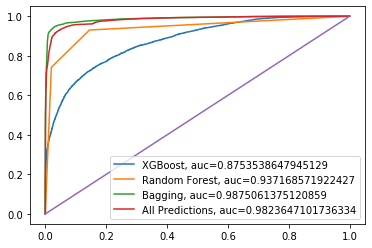

In [59]:
import matplotlib.pyplot as plt
plt.figure(0).clf()

# XGBoost
fpr, tpr, thresh = roc_curve(Y, peter_preds[:,1])
auc = roc_auc_score(Y, peter_preds[:,1])
plt.plot(fpr,tpr,label= "XGBoost, auc="+str(auc))

# RF
fpr, tpr, thresh = roc_curve(Y, alex_preds[:,1])
auc = roc_auc_score(Y, alex_preds[:,1])
plt.plot(fpr,tpr,label= "Random Forest, auc="+str(auc))

# Bagging
fpr, tpr, thresh = roc_curve(Y, jacob_preds[:,1])
auc = roc_auc_score(Y, jacob_preds[:,1])
plt.plot(fpr,tpr,label= "Bagging, auc="+str(auc))

# All predictions
allPredictions2 = ensemble.predict_proba(X)
fpr, tpr, thresh = roc_curve(Y, allPredictions2[:,1])
auc = roc_auc_score(Y, allPredictions2[:,1])
plt.plot(fpr,tpr,label="All Predictions, auc="+str(auc))

x = np.linspace(0, 1)
plt.plot(x, x)
plt.legend(loc=0)

plt.show()